In [1]:
import multiprocessing as mp
import os
import numpy as np
import pandas as pd
#from matplotlib import pyplot as plt
from keras.callbacks import History, EarlyStopping, Callback
import tensorflow as tf
print(tf.version.VERSION)
import glob as glb
import matplotlib.pyplot as plt



2.9.1


In [5]:
!pwd

/home/jmeow/git/ANNA-MOLLY/telemanom/telemanom


In [4]:
os.chdir('telemanom')
os.getcwd()

'/home/jmeow/git/ANNA-MOLLY/telemanom/telemanom'

In [6]:
from channel import Channel
from helpers import Config
import random

In [7]:
cfg = Config("config.yaml")

In [9]:
def get_rando_data(n = 5):
    ret = []
    g = glb.glob("../data/train/*")
    sel = random.choice(g).split("/")[-1].split(".")[0]
    os.chdir('../')
    for _ in range(n):
        ch = Channel(cfg, sel)
        ch.load_data()
        ret.append(ch)
    os.chdir('telemanom')
    return ret



In [10]:
ch = get_rando_data()

In [19]:
c.X_train.shape[-1]

25

In [13]:
!pwd

/home/jmeow/git/ANNA-MOLLY/telemanom/telemanom


In [15]:
np.save("pilot_X.npy", c.X_train)

In [17]:
np.save("pilot_y.npy", c.y_train)

In [8]:
from model_utils import TimeGAN

In [18]:
c = ch[1]
nfeatures = c.X_train.shape[-1]
c.X_train.shape

(2560, 250, 25)

(1772, 250, 55)

In [19]:
from keras.layers import LSTM, Input, Concatenate, Reshape, GRU
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, Flatten, RepeatVector
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential, Model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam


In [20]:
X = Input(shape=(250, 25), name='RealData')
Z = Input(shape=(250, 25), name='RandomData')

In [21]:
seq_len = 1
n_seq = 25
batch_size = 250
hidden_dim = 10

In [22]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

In [23]:
embedder = make_rnn(n_layers=3,
                    hidden_units=hidden_dim,
                    output_units=hidden_dim,
                    name='Embedder')
recovery = make_rnn(n_layers=3,
                    hidden_units=hidden_dim,
                    output_units=n_seq,
                    name='Recovery')

2022-11-22 10:27:06.594430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 10:27:06.597769: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
generator = make_rnn(n_layers=3,
                     hidden_units=hidden_dim,
                     output_units=hidden_dim,
                     name='Generator')
discriminator = make_rnn(n_layers=3,
                         hidden_units=hidden_dim,
                         output_units=1,
                         name='Discriminator')
supervisor = make_rnn(n_layers=2,
                      hidden_units=hidden_dim,
                      output_units=hidden_dim,
                      name='Supervisor')

In [25]:
train_steps = 10000
gamma = 1
mse = MeanSquaredError()
bce = BinaryCrossentropy()

In [26]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [27]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 250, 25)]         0         
                                                                 
 Embedder (Sequential)       (None, 250, 10)           2540      
                                                                 
 Recovery (Sequential)       (None, 250, 25)           2255      
                                                                 
Total params: 4,795
Trainable params: 4,795
Non-trainable params: 0
_________________________________________________________________


In [28]:
autoencoder_optimizer = Adam()

In [29]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [30]:
train_steps = c.X_train.shape[0]

In [31]:
from tqdm import tqdm
i = 0
for step in tqdm(range(train_steps)):
    X_ = c.X_train[i]
    X_ = X_.reshape(1, X_.shape[0], X_.shape[1])
    i +=1
    step_e_loss_t0 = train_autoencoder_init(X_)
    if i % 500 == 0:
        print(('Loss Autoencoder Init', step_e_loss_t0, step))
    #with writer.as_default():
    #    tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

 20%|█████████████████████████████████▏                                                                                                                                        | 500/2560 [06:42<27:11,  1.26it/s]

('Loss Autoencoder Init', <tf.Tensor: shape=(), dtype=float32, numpy=0.19680339>, 499)


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 1000/2560 [13:06<18:55,  1.37it/s]

('Loss Autoencoder Init', <tf.Tensor: shape=(), dtype=float32, numpy=0.18925264>, 999)


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 1500/2560 [19:41<12:28,  1.42it/s]

('Loss Autoencoder Init', <tf.Tensor: shape=(), dtype=float32, numpy=0.16724482>, 1499)


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 2000/2560 [26:03<07:27,  1.25it/s]

('Loss Autoencoder Init', <tf.Tensor: shape=(), dtype=float32, numpy=0.13589998>, 1999)


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 2500/2560 [32:22<00:47,  1.26it/s]

('Loss Autoencoder Init', <tf.Tensor: shape=(), dtype=float32, numpy=0.1714861>, 2499)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2560/2560 [33:09<00:00,  1.29it/s]


In [32]:
autoencoder.save('autoencoder')

INFO:tensorflow:Assets written to: autoencoder/assets


INFO:tensorflow:Assets written to: autoencoder/assets


In [33]:
supervisor_optimizer = Adam()

In [34]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [35]:
i = 0
for step in tqdm(range(train_steps)):
    X_ = c.X_train[i]
    X_ = X_.reshape(1, X_.shape[0], X_.shape[1])
    i +=1
    step_g_loss_s = train_supervisor(X_)
    if i % int(train_steps/10) == 0:
        print(('Loss Generator Supervised Init', step_g_loss_s, step))
    #with writer.as_default():
    #    tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

 10%|█████████████████                                                                                                                                                         | 256/2560 [02:14<18:29,  2.08it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=0.0002947549>, 255)


 20%|██████████████████████████████████                                                                                                                                        | 512/2560 [04:19<16:05,  2.12it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=3.1470736e-05>, 511)


 30%|███████████████████████████████████████████████████                                                                                                                       | 768/2560 [06:29<14:09,  2.11it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=2.0756506e-05>, 767)


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 1024/2560 [08:37<13:07,  1.95it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=1.4772981e-05>, 1023)


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 1280/2560 [10:46<09:33,  2.23it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=4.2631465e-05>, 1279)


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 1536/2560 [12:54<08:37,  1.98it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=2.176747e-05>, 1535)


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1792/2560 [15:04<05:49,  2.20it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=2.1587668e-05>, 1791)


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 2048/2560 [17:11<04:20,  1.96it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=2.5294426e-05>, 2047)


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 2304/2560 [19:22<01:56,  2.20it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=1.3915351e-05>, 2303)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2560/2560 [21:34<00:00,  1.98it/s]

('Loss Generator Supervised Init', <tf.Tensor: shape=(), dtype=float32, numpy=1.0360625e-05>, 2559)


In [36]:
supervisor.save("supervisor")

INFO:tensorflow:Assets written to: supervisor/assets


INFO:tensorflow:Assets written to: supervisor/assets


In [37]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 250, 25)]         0         
                                                                 
 Generator (Sequential)      (None, 250, 10)           2540      
                                                                 
 Supervisor (Sequential)     (None, 250, 10)           1430      
                                                                 
 Discriminator (Sequential)  (None, 250, 1)            1991      
                                                                 
Total params: 5,961
Trainable params: 5,961
Non-trainable params: 0
_________________________________________________________________


In [38]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 250, 25)]         0         
                                                                 
 Generator (Sequential)      (None, 250, 10)           2540      
                                                                 
 Discriminator (Sequential)  (None, 250, 1)            1991      
                                                                 
Total params: 4,531
Trainable params: 4,531
Non-trainable params: 0
_________________________________________________________________


In [39]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 250, 25)]         0         
                                                                 
 Generator (Sequential)      (None, 250, 10)           2540      
                                                                 
 Supervisor (Sequential)     (None, 250, 10)           1430      
                                                                 
 Recovery (Sequential)       (None, 250, 25)           2255      
                                                                 
Total params: 6,225
Trainable params: 6,225
Non-trainable params: 0
_________________________________________________________________


In [40]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

In [41]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 250, 25)]         0         
                                                                 
 Embedder (Sequential)       (None, 250, 10)           2540      
                                                                 
 Discriminator (Sequential)  (None, 250, 1)            1991      
                                                                 
Total params: 4,531
Trainable params: 4,531
Non-trainable params: 0
_________________________________________________________________


In [43]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

In [99]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

In [100]:
class Idata:
    def __init__(self, data):
        self.data = data
        self.i = 0
        
    def __next__(self):
        ret = self.data[self.i]
        self.i += 1
        if self.i >= len(self.data):
            self.i = 0
        return ret

In [96]:
idata = Idata(c.X_train)

3

In [183]:
idata = iter(c.X_train)
idata2 = iter(c.X_train)
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(1000):
    # Train generator (twice as often as discriminator)
    j = 0
    for kk in range(2):
        print(step,j)
        X_ = next(idata)
        X_ = X_.reshape(1, X_.shape[0], X_.shape[1]).astype('float32')
        Z_ = np.random.rand(1,250,25).astype('float32')

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(idata2)
    X_ = X_.reshape(1, X_.shape[0], X_.shape[1])
    Z_ = np.random.rand(1,250,25).astype('float32')
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    #with writer.as_default():
    #    tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
    #    tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
    #    tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
    #    tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
    #    tf.summary.scalar('D Loss', step_d_loss, step=step)

dtype('float64')

In [104]:
synthetic_data.save('synthetic_data')

INFO:tensorflow:Assets written to: synthetic_data/assets


INFO:tensorflow:Assets written to: synthetic_data/assets


In [106]:
c.X_train[0]

array([[ 0.3484108 ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.17436473,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.19344707,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.53209129,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.89963421,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.88894542,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [110]:
generated_data = []
for i in range(10):
    Z_ = np.random.rand(1,250,25).astype('float32')
    d = synthetic_data(Z_)
    generated_data.append(d)

In [116]:
!conda activate meow2


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




In [7]:
reloaded_obj = tf.saved_model.load("synthetic_data")

2022-11-22 19:55:55.296322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 19:55:55.299395: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [77]:
generated_data = []
for i in range(10):
    Z_ = np.random.rand(1,250,25).astype('float32')
    d = reloaded_obj(Z_)
    generated_data.append(d)

In [21]:
generated_data[0][0][:,0].shape

TensorShape([250])

In [32]:
c = ch[0]

In [46]:
cc = c.X_train[-1]

In [47]:
cc[

array([[-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.]])

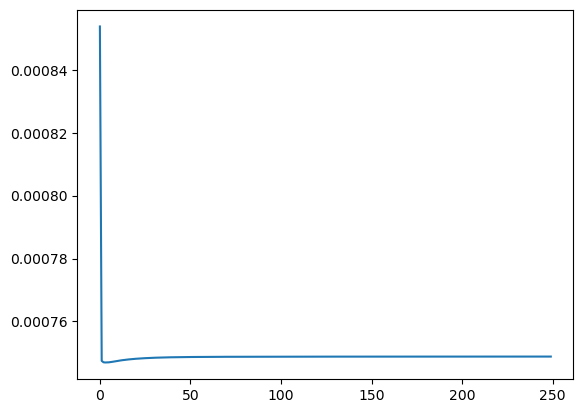

In [78]:
plt.plot(generated_data[0][0][:,15])
#plt.plot(cc[:,5])